In [307]:
import numpy as np
import os
from python_pattern_stim_analysis import PGanalysis
from phase_analysis import phase_analysis
import scipy.io
import h5py
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp
from scipy import signal
from phase_analysis import odor_phase_analysis
import importlib
from pathlib import Path
import scipy.stats as st
import astropy.stats 
import pandas as pd
import random
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import inconsistent
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [308]:
shiva_data = np.load(r'C:\Users\rmb55\most_updated_pattern_stim\pattern_stim_analysis\odor_analysis\shiva_odor_responses.npy', allow_pickle = True)[0]

In [309]:
phase_aligned_rasters_expt = shiva_data['phase_aligned_rasters_expt']

In [310]:
time_aligned_rasters_expt = shiva_data['spike_rasters_expt']

In [311]:
formatted_rasters = []
formatted_rasters_trial = []
formatted_rasters_odor = []
formatted_rasters_cell = []
for expt in time_aligned_rasters_expt:
    for cell in range(len(expt[0])):
        for odor in range(len(expt)):
            for trial in range(len(expt[0][0])):
                formatted_rasters.append(expt[odor][cell][trial])
            formatted_rasters_trial.append(formatted_rasters)
            formatted_rasters = []
        formatted_rasters_odor.append(formatted_rasters_trial)
        formatted_rasters_trial = []
    formatted_rasters_cell.append(formatted_rasters_odor)
    formatted_rasters_odor = []

In [312]:
time_aligned_rasters_cat = np.array([expt for expts in formatted_rasters_cell for expt in expts])

C:\Users\rmb55\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [313]:
time_aligned_rasters_expt = formatted_rasters_cell
n_total_cells = len(time_aligned_rasters_cat)
n_odors = len(time_aligned_rasters_cat[0])
n_trials = len(time_aligned_rasters_cat[0][0])
### Initialize array to count the number of spikes occuring in the first respiration cycle for each trial
spike_count_first_400 = np.empty((n_total_cells, n_odors, n_trials))
cell_counter = 0
for n_expt, expt in enumerate(time_aligned_rasters_expt):
    for cell in expt:
        for n_odor, odor in enumerate(cell):
            for n_trial, trial in enumerate(odor): 
                n_spikes = 0
                for spike in trial:
                    # sum the number of spikes occuring in the first full cycle for each cell for each odor trial
                    if ((spike > 0) & (spike <  .400)):
                        n_spikes+=1
                spike_count_first_400[cell_counter, n_odor, n_trial] = n_spikes
        cell_counter+=1

In [314]:
cells_activated = np.zeros((n_total_cells,n_odors))
cells_suppressed = np.zeros((n_total_cells,n_odors))
p_vals_all = np.zeros((n_total_cells,n_odors))
for odor_num in range(n_odors):
    # get the number of spikes for the selected odor 
    p1 = spike_count_first_400[:,odor_num, :]
    # get the number of spikes in response to mineral oil 
    p2 = spike_count_first_400[:,0,:]
    # perform a significance test to find significantly activated and suppressed cells
    pvals,auroc = PGanalysis.twoptn_rank_sum_test(p1,p2)
    p_vals_all[:, odor_num] = pvals
    cells_activated[(np.where((pvals<.01) & (auroc>.5))[0]), odor_num] = 1
    cells_suppressed[(np.where((pvals<.01) & (auroc<.5))[0]), odor_num] = 1

In [315]:
# get the mean spike phase in the first breath for each trial 
mean_latency_first_400 = np.empty((n_total_cells, n_odors, n_trials))
cell_counter = 0
spikes_all = []
for n_expt, expt in enumerate(time_aligned_rasters_expt):
    for cell in expt:
        for n_odor, odor in enumerate(cell):
            for n_trial, trial in enumerate(odor): 
                spikes = []
                for spike in trial:
                    if ((spike > 0) & (spike <  .4)):
                        spikes.append(spike)
                mean_latency_first_400[cell_counter, n_odor, n_trial] = np.mean(spikes)
        cell_counter+=1

C:\Users\rmb55\virtual_environments\pattern-stim3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\rmb55\virtual_environments\pattern-stim3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [316]:
# get the mean phase of spikes for each cell in response to each odor for significantly activated cells
trial_mean_n_spikes = np.zeros((n_total_cells,n_odors))+np.nan
trial_mean_latency = np.zeros((n_total_cells,n_odors))+np.nan
for cell_n, cell in enumerate(mean_latency_first_400):
    for odor_n, odor in enumerate(cell):
        if sum(~np.isnan(odor))>0:
            trial_mean_latency[cell_n, odor_n] = np.mean(odor[~np.isnan(odor)])
            trial_mean_n_spikes[cell_n, odor_n]  = np.nanmean(spike_count_first_400[cell_n,odor_n])
        else:
            trial_mean_latency[cell_n, odor_n] = np.nan
            trial_mean_n_spikes[cell_n, odor_n] = np.nan

In [317]:
# now for each cell, extract the response latencies only for significantly actvating odors. 
all_mean_latencies = []
pref_latency = []
for cell_n, cell in enumerate(cells_activated):
    # get the latencies for significantly activating odors 
    latencies_activated_cells = trial_mean_latency[cell_n, np.where(cell>0)[0]]
    # get the number of spikes evoked by each significantly activating odor
    act_idx = np.where(cell>0)[0]
    spikes_act_idx = trial_mean_n_spikes[cell_n, act_idx]
    # if cell responds to more than one odor, append response latencies to nested list 
    if len(latencies_activated_cells)>1:
        # for each set of latencies, sort the latencies by the number of spikes evoked by each odor. In each array, the first element is the preferred odorant.
        all_mean_latencies.append(latencies_activated_cells[np.flipud(np.argsort(spikes_act_idx))])

In [318]:
# calculate the mean latency for each cell 
mean_mean_latencies = []
for cell in all_mean_latencies:
    mean_mean_latencies.append(scipy.stats.circmean(cell))

In [319]:
# sort the cells in ascending order by mean latency 
sort_order = np.flipud(np.argsort(mean_mean_latencies))

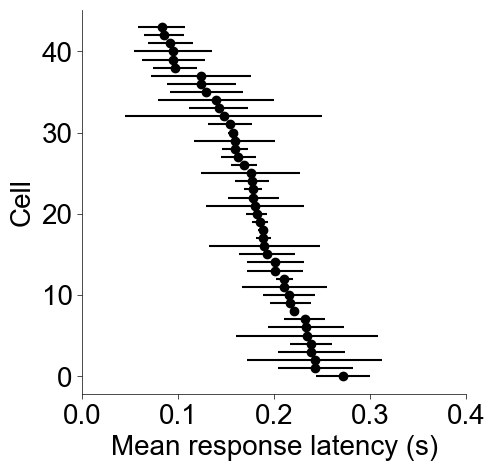

In [320]:
all_mean_latencies_sorted = []
all_cell_indices_sorted = []
all_latency_standard_deviations = []
cell_n = 0
for cell in sort_order:
    if len(all_mean_latencies[cell])>2:
        plt.plot(np.mean(all_mean_latencies[cell]), cell_n,'ko')
        plt.errorbar(np.mean(all_mean_latencies[cell]), cell_n, xerr = np.std(all_mean_latencies[cell]), color = 'k')
        all_mean_latencies_sorted.append(all_mean_latencies[cell])
        all_cell_indices_sorted.append(np.zeros(len(all_mean_latencies[cell]))+cell_n)
        all_latency_standard_deviations.append(np.std(all_mean_latencies[cell]))
        cell_n+=1
plt.xlim(0,.4)
#plt.ylim(0,60)
plt.ylabel('Cell')
plt.xlabel('Mean response latency (s)')
PGanalysis.axis_fixer(ratio = 1, size = 20)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\mean_std_response_phase.pdf', bbox_inches = 'tight')

In [321]:
np.mean(all_latency_standard_deviations)

0.0311111733808539

In [322]:
all_mean_latencies_sorted_flat = [latency for latencies in all_mean_latencies_sorted for latency in latencies]
bootstrapped_stds = np.empty(1000)
for iteration in range(1000):
    random.seed(iteration)
    new_shuffled_std = []
    random.shuffle(all_mean_latencies_sorted_flat)
    idx = 0
    for cell in all_mean_latencies_sorted:
        grab_n = len(cell)
        new_shuffled_std.append(np.std(all_mean_latencies_sorted_flat[idx:idx+grab_n]))
        idx += grab_n
    bootstrapped_stds[iteration] = np.mean(new_shuffled_std)

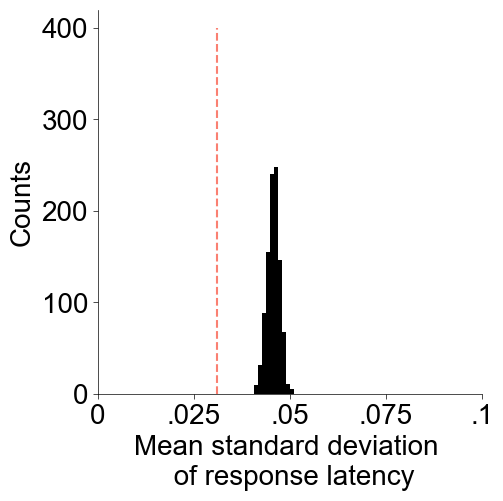

In [323]:
# plot a histogram of the mean standard deviations across 1000 iterations of randomly generated preferred phases
# additionally, plot the observed mean 
plt.hist(bootstrapped_stds, color = 'k')
std_mean_observed = np.mean(all_latency_standard_deviations)
plt.plot([std_mean_observed, std_mean_observed], [0,400], linestyle = '--', color = 'salmon')
plt.xlabel('Mean standard deviation \n of response latency')
plt.ylabel('Counts')
plt.xlim(0,.1)
plt.xticks([0,.025,.05,.075,.1], labels = ['0','.025','.05','.075','.1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\bootstrapped_std.pdf', bbox_inches = 'tight')

In [282]:
time_aligned_PSTHs_expt_cat = np.array([expt for expts in shiva_data['time_aligned_PSTHs_expt'] for expt in expts])
x = np.arange(-5,5,.002)
analyze_resp = np.where((x>0) & (x<.8))[0]
time_aligned_psth_analyze = time_aligned_PSTHs_expt_cat[:,:,:,analyze_resp]
time_aligned_psth_analyze_mean = np.mean(time_aligned_psth_analyze,2)

In [283]:
time_aligned_psth_analyze_mean.shape

(840, 11, 400)

In [284]:
analyze_indices_pre = np.where((x>-.8)&(x<0))[0][0:]
spontaneous_PSTHs = np.mean(time_aligned_PSTHs_expt_cat[:, :, :, analyze_indices_pre],(1,2))

In [285]:
'''For each pair of neurons i and j, we computed the Euclidian distance dif between
the PETHs of neuron i in the first condition and neuron j in the second condition. To account for
differences in firing rates each PETH was normalized between 0 and 1.The PETH consistency
measure of neuron i was defined to be the percentage of all other neurons j for which dii < dij'''

def get_PSTH_similarity(cells_activated, valve_PSTHs_analyze):
    '''
    Parameters 
    ----------
    cells_activated: an n_cells x n_valves matrix. Value set to 1 if cell is significantly activated with respect to mineral oil response. 
    valve_PSTHs_analyze: the trial averaged PSTHs for each cell over the response window period
    
    Outputs
    -------
    similarity_mats: a list of n_cells x n_cells binary matrices. 1 indicates that the dii<dij. 0 indicates that dii>dij. 
    
    '''
    similarity_mats = []
    distance_mats = []
    all_distances = []
    neuron_distance = []
    test_similarity_mat = []
    n_valves = valve_PSTHs_analyze.shape[1]
    # loop throught each pair of odors 
    for odor1 in range(1,n_valves):
        for odor2 in range(1,n_valves):
            # find the indices of cells that respond significantly to both odors
            multi_tuned_idx = np.where(np.sum(cells_activated[:,[odor1,odor2]],1)>1)[0]
            similarity_mat = np.zeros((len(multi_tuned_idx), len(multi_tuned_idx)))
            distance_matrix = np.zeros((len(multi_tuned_idx), len(multi_tuned_idx)))
            # Now loop through the significantly responsive cells for all odor pairs 
            neuron_PSTH_distance = []
            for n1, cell1 in enumerate(valve_PSTHs_analyze[multi_tuned_idx,odor1,:]):
                #First, find the distance between the same cell's response to odor1 and odor2
                cell1_norm_odor1 = cell1/np.max(cell1)
                cell1_norm_odor2 = valve_PSTHs_analyze[multi_tuned_idx[n1], odor2,:]/np.max(valve_PSTHs_analyze[multi_tuned_idx[n1], odor2,:])
                self_distance = np.linalg.norm((cell1_norm_odor1-cell1_norm_odor2))
                # Now, loop through the rest of the cells and calculate the distance between cell 1's response to odor 1 and cell 2's response to odor 2. 
                for n2, cell2 in enumerate(valve_PSTHs_analyze[multi_tuned_idx,odor2,:]):
                    cell1_norm = cell1/np.max(cell1)
                    cell2_norm = cell2/np.max(cell2)
                    PSTH_distance = np.linalg.norm((cell1_norm-cell2_norm))
                    if (self_distance<PSTH_distance):
                        similarity_mat[n1,n2] = 1
                    if n1 == n2:
                        similarity_mat[n1,n2] = np.nan

            # Append the matrices for all odor pairs 
            if odor1 != odor2: 
                similarity_mats.append(similarity_mat)
            distance_mats.append(distance_matrix)
            
    return similarity_mats

In [286]:
similarity_mats_odors = get_PSTH_similarity(cells_activated, time_aligned_psth_analyze_mean)

In [287]:
odor_mean_distances = []
for mat in similarity_mats_odors:
    odor_mean_distances.append(np.nanmean(mat))

In [288]:
'''For each pair of neurons i and j, we computed the Euclidian distance dif between
the PETHs of neuron i in the first condition and neuron j in the second condition. To account for
differences in firing rates each PETH was normalized between 0 and 1.The PETH consistency
measure of neuron i was defined to be the percentage of all other neurons j for which dii < dij'''

def get_PSTH_similarity_shuff(cells_activated, valve_PSTHs_analyze):
    '''
    Parameters 
    ----------
    cells_activated: an n_cells x n_valves matrix. Value set to 1 if cell is significantly activated with respect to mineral oil response. 
    valve_PSTHs_analyze: the trial averaged PSTHs for each cell over the response window period
    
    Outputs
    -------
    similarity_mats: a list of n_cells x n_cells binary matrices. 1 indicates that the dii<dij. 0 indicates that dii>dij. 
    
    '''
    similarity_mats = []
    all_distances = []
    neuron_distance = []
    n_valves = valve_PSTHs_analyze.shape[1]
    # loop throught each pair of odors 
    for odor1 in range(1,n_valves):
        for odor2 in range(1,n_valves):
            # find the indices of cells that respond significantly to both odors
            multi_tuned_idx = np.where(np.sum(cells_activated[:,[odor1,odor2]],1)>1)[0]
            multi_tuned_idx_rand = np.copy(multi_tuned_idx)
            np.random.shuffle(multi_tuned_idx_rand)
            similarity_mat = np.zeros((len(multi_tuned_idx), len(multi_tuned_idx)))
            # Now loop through the significantly responsive cells for all odor pairs 
            neuron_PSTH_distance = []
            for n1, cell1 in enumerate(valve_PSTHs_analyze[multi_tuned_idx,odor1,:]):
                #First, find the distance between the same cell's response to odor1 and odor2
                cell1_norm_odor1 = cell1/np.max(cell1)
                cell1_norm_odor2 = valve_PSTHs_analyze[multi_tuned_idx_rand[n1], odor2,:]/np.max(valve_PSTHs_analyze[multi_tuned_idx_rand[n1], odor2,:])
                self_distance = np.linalg.norm((cell1_norm_odor1-cell1_norm_odor2))
                # Now, loop through the rest of the cells and calculate the distance between responses to odor 1 and odor 2. 
                for n2, cell2 in enumerate(valve_PSTHs_analyze[multi_tuned_idx_rand,odor2,:]):
                    cell1_norm = cell1/np.max(cell1)
                    cell2_norm = cell2/np.max(cell2)
                    PSTH_distance = np.linalg.norm((cell1_norm-cell2_norm))
                    if (self_distance<PSTH_distance):
                        similarity_mat[n1,n2] = 1
                    if n1 == n2:
                        similarity_mat[n1,n2] = np.nan

            # Append the matrices for all odor pairs 
            if odor1 != odor2: 
                similarity_mats.append(similarity_mat)
            
    return similarity_mats

In [289]:
similarity_mats_spont = get_PSTH_similarity_spont(cells_activated, time_aligned_psth_analyze_mean, spontaneous_PSTHs)

In [290]:
spont_mean_distances = []
for mat in similarity_mats_spont:
    spont_mean_distances.append(np.nanmean(mat))

In [291]:
'''For each pair of neurons i and j, we computed the Euclidian distance dif between
the PETHs of neuron i in the first condition and neuron j in the second condition. To account for
differences in firing rates each PETH was normalized between 0 and 1.The PETH consistency
measure of neuron i was defined to be the percentage of all other neurons j for which dii < dij'''

def get_PSTH_similarity_spont_shuff(cells_activated, valve_PSTHs_analyze, spontaneous_PSTHs):
    '''
    Parameters 
    ----------
    cells_activated: an n_cells x n_valves matrix. Value set to 1 if cell is significantly activated with respect to mineral oil response. 
    valve_PSTHs_analyze: the trial averaged PSTHs for each cell over the response window period
    
    Outputs
    -------
    similarity_mats: a list of n_cells x n_cells binary matrices. 1 indicates that the dii<dij. 0 indicates that dii>dij. 
    
    '''
    similarity_mats = []
    all_distances = []
    neuron_distance = []
    n_valves = valve_PSTHs_analyze.shape[1]
    # loop throught each pair of odors 
    for odor1 in range(1,n_valves):
        # find the indices of cells that respond significantly to both odors
        multi_tuned_idx = np.where(cells_activated[:,odor1]>0)[0]
        multi_tuned_idx_rand = np.copy(multi_tuned_idx)
        np.random.shuffle(multi_tuned_idx_rand)
        similarity_mat = np.zeros((len(multi_tuned_idx), len(multi_tuned_idx)))
        # Now loop through the significantly responsive cells for all odor pairs 
        neuron_PSTH_distance = []
        for n1, cell1 in enumerate(valve_PSTHs_analyze[multi_tuned_idx,odor1,:]):
            #First, find the distance between the same cell's response to odor1 and odor2
            cell1_norm_odor1 = cell1/np.max(cell1)
            cell1_norm_odor2 = spontaneous_PSTHs[multi_tuned_idx_rand[n1], :]/np.max(spontaneous_PSTHs[multi_tuned_idx_rand[n1], :])
            self_distance = np.linalg.norm((cell1_norm_odor1-cell1_norm_odor2))
            # Now, loop through the rest of the cells and calculate the distance between responses to odor 1 and odor 2. 
            for n2, cell2 in enumerate(spontaneous_PSTHs[multi_tuned_idx_rand,:]):
                cell1_norm = cell1/np.max(cell1)
                cell2_norm = cell2/np.max(cell2)
                PSTH_distance = np.linalg.norm((cell1_norm-cell2_norm))
                if (self_distance<PSTH_distance):
                    similarity_mat[n1,n2] = 1
                if n1 == n2:
                    similarity_mat[n1,n2] = np.nan
                #all_distances.append(neuron_PSTH_distance)
        # Append the matrices for all odor pairs 
        similarity_mats.append(similarity_mat)
    return similarity_mats

In [292]:
similarity_mats_spont_shuff = get_PSTH_similarity_spont_shuff(cells_activated, time_aligned_psth_analyze_mean, spontaneous_PSTHs)

In [293]:
spont_mean_distances_shuff = []
for mat in similarity_mats_spont_shuff:
    spont_mean_distances_shuff.append(np.nanmean(mat))

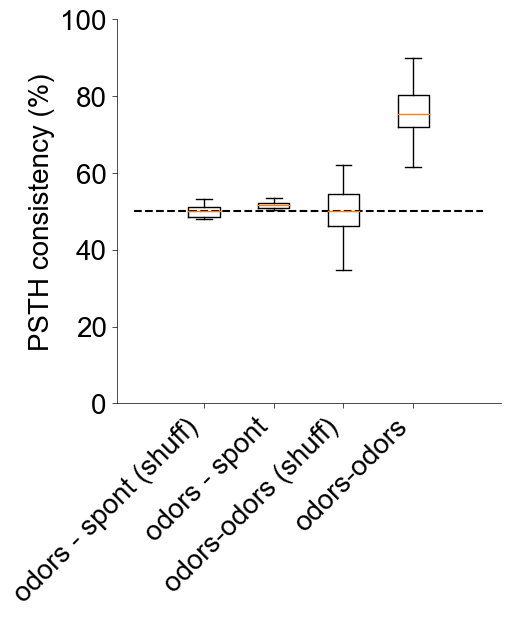

In [294]:
plt.boxplot([spont_mean_distances_shuff, spont_mean_distances, odor_mean_distances_shuff, odor_mean_distances], showfliers = False)
plt.ylim(0,1)
plt.plot([0,5],[.5,.5],'k--')
plt.ylabel('PSTH consistency (%)')
plt.xticks([1,2,3,4], ['odors - spont (shuff)', 'odors - spont', 'odors-odors (shuff)', 'odors-odors'], rotation = 45, ha = 'right')
plt.yticks([0,.2,.4,.6,.8,1], labels = ['0','20','40','60','80','100'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

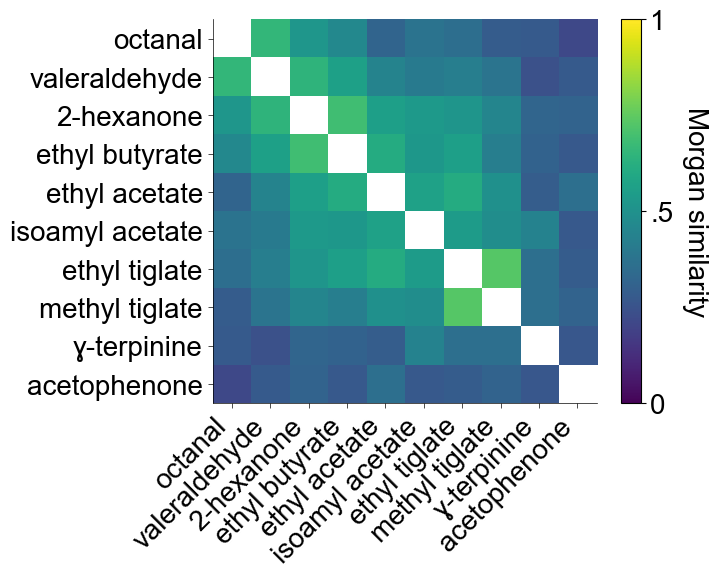

In [295]:
# Perform hierarchical clustering to visualize the odor similarity matrix
morgan_similarity_mat = np.load(r'Z:\robin\thesis\figures\chapter4\data\morgan_similarity_shiva.npy', allow_pickle = True)

np.fill_diagonal(morgan_similarity_mat, 1)

df = pd.DataFrame(morgan_similarity_mat, columns=[f'Item_{i+1}' for i in range(10)])

# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(df, method='average', metric='euclidean', optimal_ordering = 1)

# Sort the correlation matrix based on the dendrogram
sorted_indices = hierarchy.leaves_list(linkage_matrix)

sorted_indices = hierarchy.leaves_list(linkage_matrix)
sorted_df = df.iloc[sorted_indices, sorted_indices]

odors = ['min oil', '2-hexanone', 'octanal', 'isoamyl acetate', 'ethyl butyrate', 'valeraldehyde', 'ethyl tiglate', 'acetophenone', 'ɣ-terpinine', 'ethyl acetate', 'methyl tiglate']
sorted_odors = np.array(odors[1:])[sorted_indices.astype(int)]

sorted_morgan = sorted_df.to_numpy()
np.fill_diagonal(sorted_morgan, np.nan)
plt.imshow(sorted_morgan)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)

ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.5,1])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Morgan similarity', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','.5','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

In [296]:
all_similarity = []
for mat in similarity_mats_odors:
    # get the proportion of ones (dii<dij) in the similarity matrix. 
    # each matrix is size n_cells x n_cells that responded to the odor pair. For each pair of cells, if the distance between cell 1's response to odor 1 and odor 2 is less than the distance between cell 1's response to odor 1 and cell 2's response to odor 2, then the matrix contains a 1.
    # Here we calculate the percentage of pairs for which the similarity between odor 1 and 2 for a given cell is greater than the similarity between two different cell's responses to odor 1 and 2. 
    similarity = np.nanmean(mat)
    all_similarity.append(similarity)

In [297]:
# Reshape data into a matrix of average similarity metrics 
odor_similarity_mat = np.empty((len(sorted_odors),len(sorted_odors)))
counter = 0
for odor1 in range(len(sorted_odors)):
    for odor2 in range(len(sorted_odors)):
        if odor1 == odor2:
            odor_similarity_mat[odor1,odor2] = np.nan
        else:
            odor_similarity_mat[odor1,odor2] = all_similarity[counter]
            counter+=1

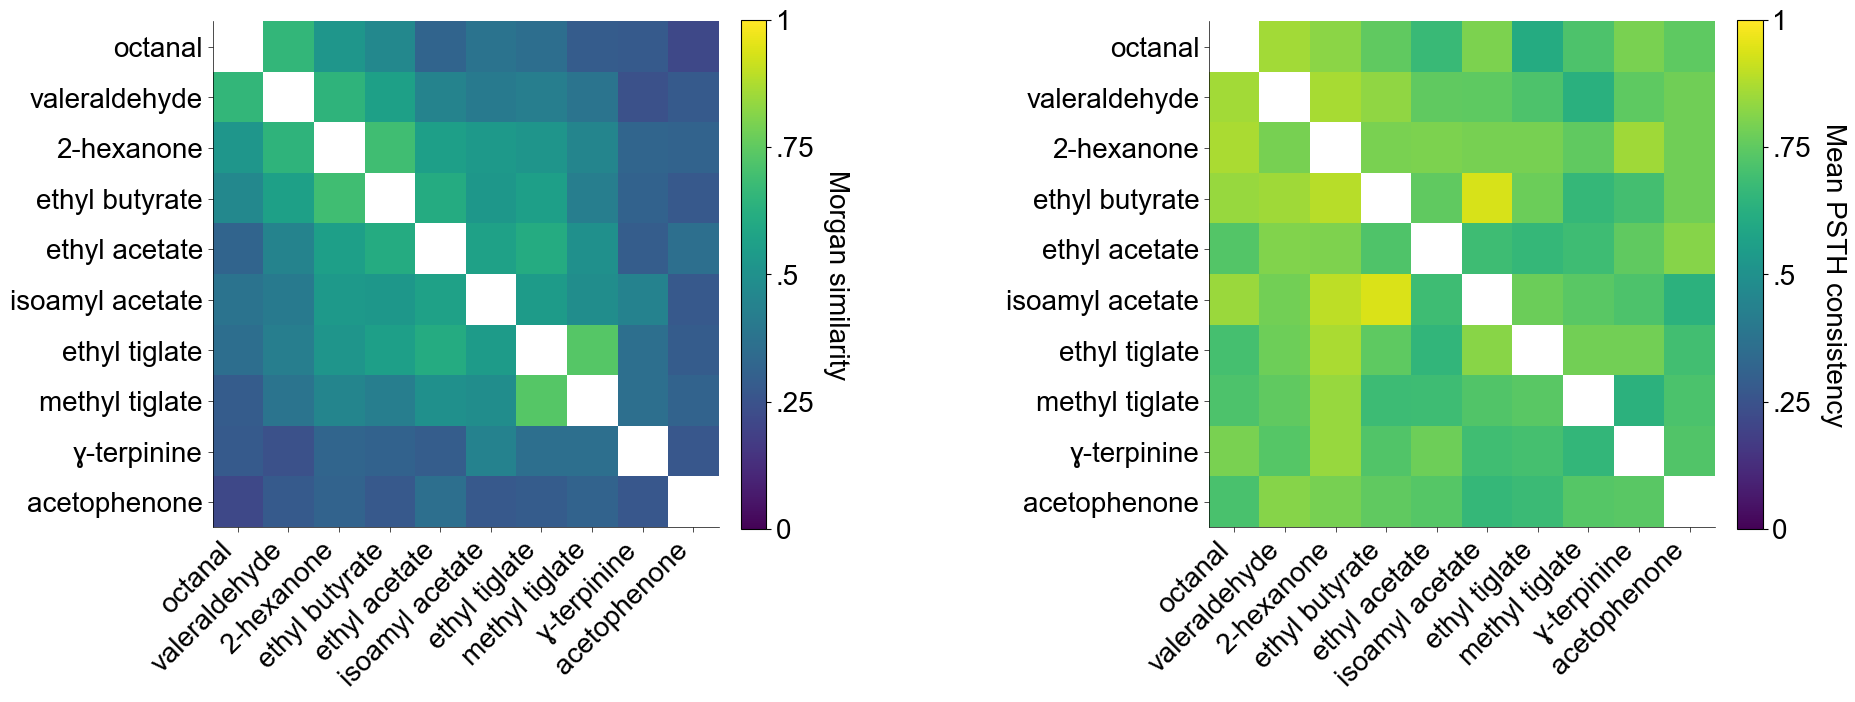

In [298]:
plt.figure(figsize = (20,20))

plt.subplot(1,2,1)
ax = plt.gca()
plt.imshow(sorted_morgan)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)


cbar = plt.colorbar(ticks = [0,.25,.5,.75,1],fraction=0.046, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Morgan similarity', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','.25','.5','.75','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

plt.subplot(1,2,2)
# use the indices of the sorted odors to plot the PSTH consistency matrix
odor_similarity_mat = pd.DataFrame(odor_similarity_mat, columns=[f'Item_{i+1}' for i in range(10)])
sorted_odor_similarity_mat = odor_similarity_mat.iloc[sorted_indices, sorted_indices]
plt.imshow(sorted_odor_similarity_mat)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)
ax = plt.gca()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Mean PSTH consistency', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.set_ticks([0,.25,.5,.75,1])
cbar.ax.set_yticklabels(['0','.25','.5','.75','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

[[1.        0.3293845]
 [0.3293845 1.       ]]


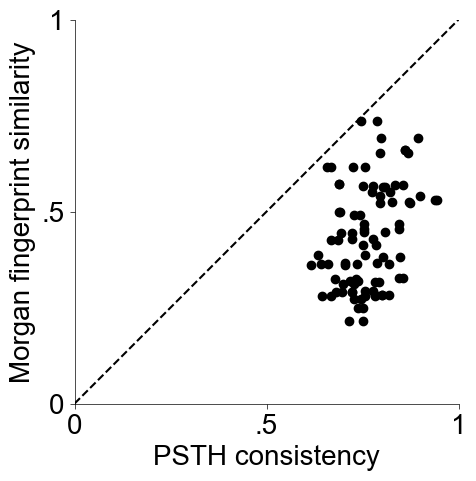

In [299]:
# now, plot the odor similarity vs consistency for each odor pair, then calculate the correlation between these two variables. 
sorted_morgan_similarity_ravel = np.ravel(sorted_morgan)
sorted_morgan_similarity_ravel = sorted_morgan_similarity_ravel[~np.isnan(sorted_morgan_similarity_ravel)]
sorted_odor_similarity_mat_ravel = np.ravel(sorted_odor_similarity_mat)
sorted_odor_similarity_mat_ravel = sorted_odor_similarity_mat_ravel[~np.isnan(sorted_odor_similarity_mat_ravel)]
plt.plot(sorted_odor_similarity_mat_ravel, sorted_morgan_similarity_ravel,'ko')
print(np.corrcoef(sorted_odor_similarity_mat_ravel, sorted_morgan_similarity_ravel))
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],'k--')
plt.xticks([0,.5,1], ['0','.5','1'])
plt.yticks([0,.5,1], ['0','.5','1'])
plt.xlabel('PSTH consistency')
plt.ylabel('Morgan fingerprint similarity')
PGanalysis.axis_fixer(ratio = 1, size = 20)

In [300]:
scipy.stats.pearsonr(sorted_odor_similarity_mat_ravel, sorted_morgan_similarity_ravel)

(0.3293845021569491, 0.0015238925880477817)

In [301]:
### Initialize array to count the number of spikes occuring in the first respiration cycle for each trial
spike_count_pre_400 = np.empty((n_total_cells, n_odors, n_trials))
cell_counter = 0
for n_expt, expt in enumerate(time_aligned_rasters_expt):
    for cell in expt:
        for n_odor, odor in enumerate(cell):
            for n_trial, trial in enumerate(odor): 
                n_spikes = 0
                for spike in trial:
                    # sum the number of spikes occuring in the first full cycle for each cell for each odor trial
                    if ((spike > -.4) & (spike <  0)):
                        n_spikes+=1
                spike_count_pre_400[cell_counter, n_odor, n_trial] = n_spikes
        cell_counter+=1

In [302]:
# for each cell compute mean and standard deviation of pre-inhalation spikes:
spike_count_pre_400_mean = np.mean(spike_count_pre_400, (1,2))
spike_count_pre_400_std = np.std(spike_count_pre_400, (1,2))

In [303]:
trial_mean_spike_counts = np.mean(spike_count_first_400,2)

mean_spike_count_correlation_matrix = np.empty((10, 10))
for odor_idx1, odor1 in enumerate(range(1,11)):
    for odor_idx2, odor2 in enumerate(range(1,11)):
            mean_spike_count_correlation_matrix[odor_idx1, odor_idx2] = np.corrcoef((trial_mean_spike_counts[:,odor1]-spike_count_pre_400_mean)/spike_count_pre_400_std, (trial_mean_spike_counts [:,odor2]-spike_count_pre_400_mean)/spike_count_pre_400_std)[0,1]

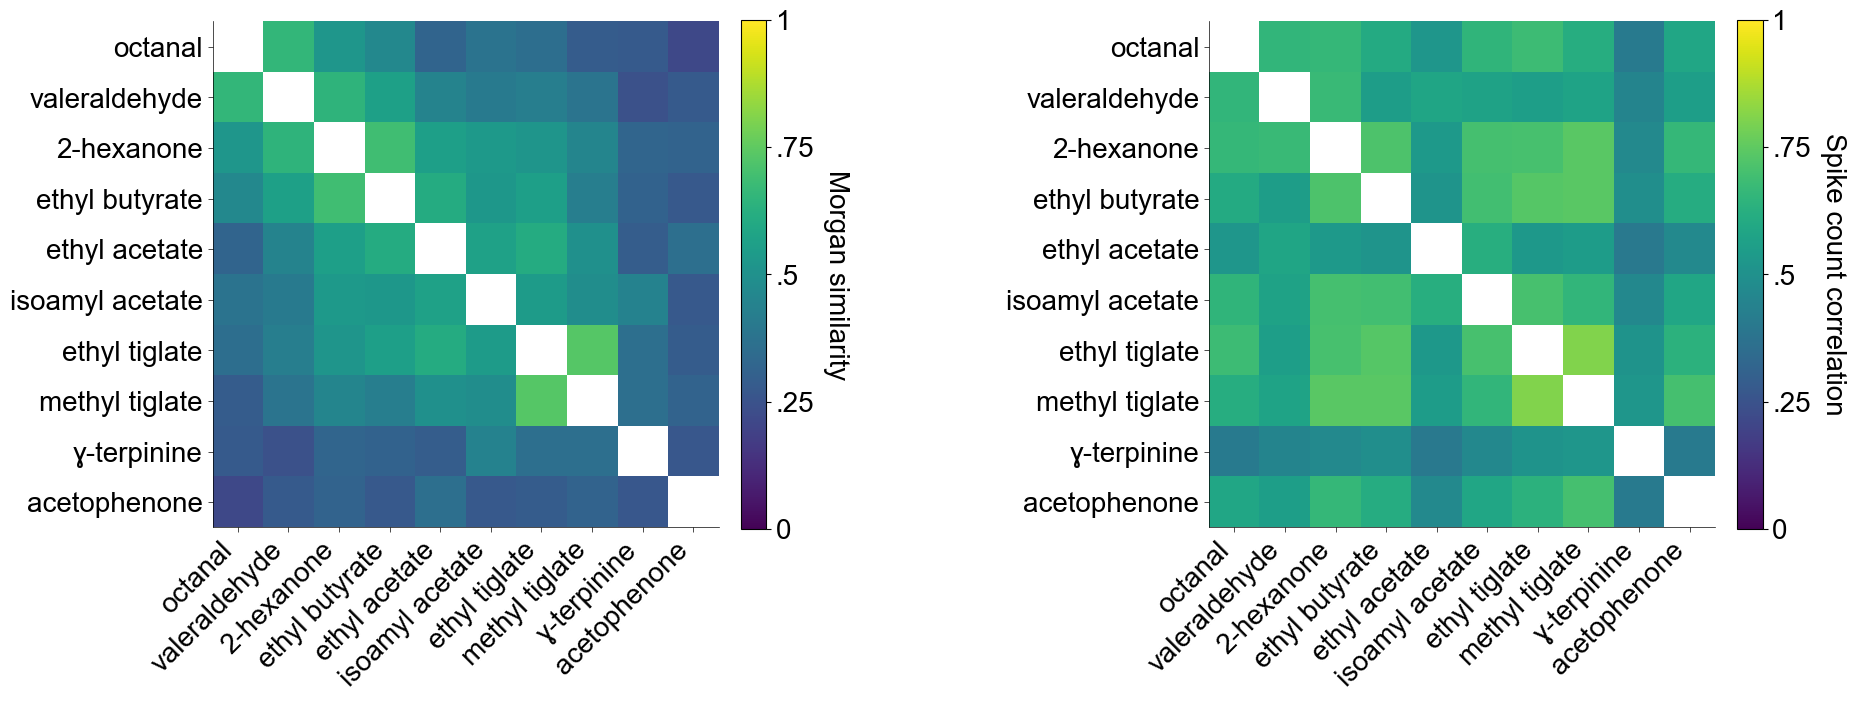

In [304]:
plt.figure(figsize = (20,20))

plt.subplot(1,2,1)
ax = plt.gca()
plt.imshow(sorted_morgan)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)


cbar = plt.colorbar(ticks = [0,.25,.5,.75,1],fraction=0.046, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Morgan similarity', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','.25','.5','.75','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

plt.subplot(1,2,2)
np.fill_diagonal(mean_spike_count_correlation_matrix, np.nan)
df = pd.DataFrame(mean_spike_count_correlation_matrix, columns=[f'Item_{i+1}' for i in range(10)])
sorted_spike_count_correlation_matrix = df.iloc[sorted_indices, sorted_indices]
plt.imshow(sorted_spike_count_correlation_matrix)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)

cbar = plt.colorbar(ticks = [0,.25,.5,.75,1],fraction=0.046, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Spike count correlation', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','.25','.5','.75','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

[[1.         0.49028436]
 [0.49028436 1.        ]]


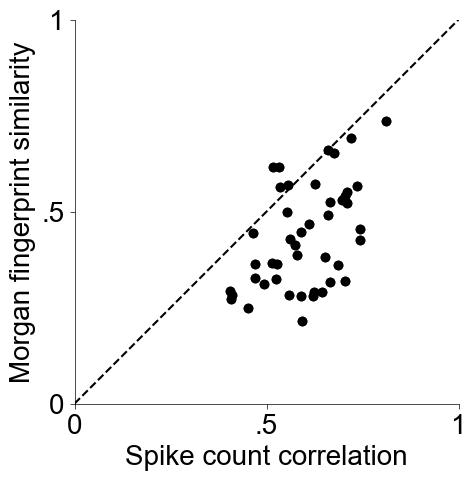

In [305]:
sorted_spike_count_correlation_ravel = np.ravel(sorted_spike_count_correlation_matrix)
sorted_spike_count_correlation_ravel = sorted_spike_count_correlation_ravel[~np.isnan(sorted_spike_count_correlation_ravel)]
plt.plot(sorted_spike_count_correlation_ravel,sorted_morgan_similarity_ravel,'ko')
print(np.corrcoef(sorted_spike_count_correlation_ravel, sorted_morgan_similarity_ravel))
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],'k--')
plt.xticks([0,.5,1], ['0','.5','1'])
plt.yticks([0,.5,1], ['0','.5','1'])
plt.xlabel('Spike count correlation')
plt.ylabel('Morgan fingerprint similarity')
PGanalysis.axis_fixer(ratio = 1, size = 20)

In [306]:
scipy.stats.pearsonr(sorted_spike_count_correlation_ravel,  sorted_morgan_similarity_ravel)

(0.49028435503508083, 9.336159989845743e-07)